In [1]:
import os
import sys
import numpy as np
import pandas as pd
import time

from looti import dictlearn as dcl
from looti import datahandle as dhl
from looti import PlottingModule as pm

from looti import tools as too
from looti import PlottingModule as pm
from looti import interpolatingObject as ito

import pickle
import joblib

In [2]:
import emcee
import pyccl as ccl
from multiprocessing import Pool

In [3]:
%matplotlib inline

In [4]:
#n_train = 30 # Number of training vectors without taking acount the extrema 
#
#npca = 30
#
#filename='../interpolating_objects/CDEfittings-interpObj-new.sav'
#
#if not too.fileexists(filename):
#    Interpolation = ito.Interpolating_function()
#
#    for i,redshift in enumerate(emulation_data.z_requested):
#
#        ratios_predicted , emulation_data,interpolation_function = dcl.Predict_ratio(emulation_data,Operator = "PCA",
#                                                              train_noise = 1e-3, ##noise for the GP's kernel
#                                                              gp_n_rsts = 10,##times allowed to restart the optimiser
#                                                              ncomp=npca , ##number of components
#                                                              gp_const = 1, ##Constant for the RBF kernel
#                                                              gp_length = 1 , ## Length for  GP 
#                                                              interp_type='GP', ##kind of interpolator,e.g int1d or GP 
#                                                              n_splits = 1, ##number of splits
#                                                              n_train=n_train, 
#                                                               n_test=0,
#                                                             train_redshift_indices = [i],
#                                                             test_redshift_indices = [i],##indices of the test vectors
#                                                             min_k =1e-2,max_k=10e1,return_interpolator=True)
#        function = ito.Interpolating_function_redshift (emulation_data,interpolation_function,redshift,normalize=True)
#        Interpolation.redshift_available.append(redshift)
#        Interpolation.list_interpolation_function.append(function)
#    with open(filename, 'wb') as f:
#        joblib.dump(Interpolation, f)
#else:
#    print("File with interpolation object exists: ", filename)
#    
#print("Loading file from joblib")
#with open(filename, 'rb') as f:
#    Interpolation_loaded = joblib.load(f)

In [63]:
truth_ratio_data_path = './obs_data/ratio-Codecs-website-truth-norm-beta0p1-z0.txt'#"./obs_data/Pk-Codecs-website-z0-beta0p10.txt"
truth_omegam=0.32
truth_beta=0.1
truth_z=0.
truth_param_arr = np.array([truth_omegam, truth_beta])

In [64]:
obs_vec = np.loadtxt(truth_ratio_data_path)
kgrid_obs=obs_vec[:,0]
pk_obs = obs_vec[:,1]

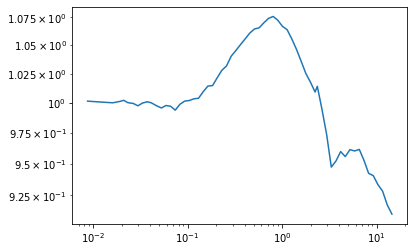

In [65]:
plt.loglog(kgrid_obs, pk_obs)

In [66]:
def obs_truth_power(cosmo_param, obs_ratio):
    zfix=0.
    afix = 1/(1+zfix)
    Omega_m, beta = cosmo_param
    Omega_b = 0.048
    ns =0.95
    bias =2.
    h=0.70
    As109=2.2
    sigma8=0.95
    
      #np.logspace(np.log10(0.012), np.log10(5.0), 31)
        
    cosmo = ccl.Cosmology(Omega_c=Omega_m-Omega_b,
                       Omega_b=Omega_b,
                       h=h,
                       #A_s=As109*10**(-9),
                       sigma8=sigma8,
                       n_s=ns,
                       transfer_function='eisenstein_hu',
                       matter_power_spectrum='halofit')
    
    kspace=obs_ratio[:,0]
    pk_obs_ratio = obs_ratio[:,1]
    
    pknonlin_ccl=np.array([ccl.power.nonlin_matter_power(cosmo, kk, afix) for kk in kspace])
    
    pknonlin_beta_recon=pknonlin_ccl*pk_obs_ratio
    
    return pknonlin_beta_recon, pknonlin_ccl

In [67]:
obs_truth_pk, ref_pk = obs_truth_power(truth_param_arr, obs_vec)

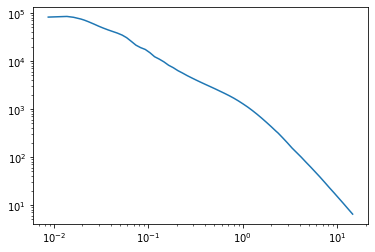

In [68]:
plt.loglog(kgrid_obs, obs_truth_pk)

In [69]:
obs_truth_pk = np.column_stack((kgrid_obs, obs_truth_pk))

In [ ]:
truth_data_path = './obs_data/Pk_ratioTimesCCL-Codecs-website-truth-norm-beta0p1-z0.txt'

In [70]:
np.savetxt(truth_data_path, obs_truth_pk)

In [71]:
filename_codecs='../interpolating_objects/CDE_ratio-Codecs_Website-z0-interpObj.sav'
print("Loading file from joblib")
with open(filename_codecs, 'rb') as f:
    Interpolation_Codecs_loaded = joblib.load(f)

Loading file from joblib


In [72]:
codecs_pred_ratio_10=[Interpolation_Codecs_loaded.predict(kki,0.10) for kki in kgrid_obs]

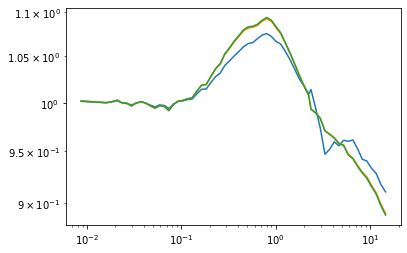

In [73]:
plt.loglog(kgrid_obs, pk_obs)
plt.loglog(kgrid_obs, codecs_pred_ratio_05)
plt.loglog(kgrid_obs, codecs_pred_ratio_10)

In [74]:
filename_fits='../interpolating_objects/CDE_ratio-CDE_Fits-z0-interpObj.sav'
print("Loading file from joblib")
with open(filename_fits, 'rb') as f:
    Interpolation_Fits_loaded = joblib.load(f)

Loading file from joblib


In [75]:
shortkgrid=kgrid_obs[(kgrid_obs>1e-2) & (kgrid_obs<4)]

In [76]:
fits_pred_ratio_10=[Interpolation_Fits_loaded.predict(kki,0.10) for kki in shortkgrid]
fits_pred_ratio_05=[Interpolation_Fits_loaded.predict(kki,0.05) for kki in shortkgrid]

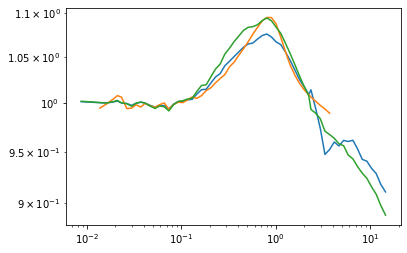

In [77]:
plt.loglog(kgrid_obs, pk_obs)
plt.loglog(shortkgrid, fits_pred_ratio_10)
#plt.loglog(shortkgrid, fits_pred_ratio_05)
plt.loglog(kgrid_obs, codecs_pred_ratio_10)

In [78]:
def center_to_bins(center):
    arr_mean =  0.5*(center[1:] + center[:-1])
    arr_start = center[0] - (arr_mean[0]-center[0])
    arr_end = center[-1] + (center[-1]-arr_mean[-1])
    return np.concatenate(([arr_start],arr_mean,[arr_end]))

def bins_to_center(bins):
    center = 0.5*(bins[1:] + bins[:-1])
    return center

In [79]:
def get_obs_datavector(data_path=truth_data_path, grid_min=0.2, grid_max=2.0):    
       
    obs_arr_full = np.loadtxt(truth_data_path)
    obs_grid_full = obs_arr_full[:,0]
    
    mask = ((obs_grid_full>grid_min) & (obs_grid_full<grid_max))
    
    obs_arr = np.copy(obs_arr_full)
    obs_arr = obs_arr[mask]
    obs_vec = obs_arr[:,1]
    obs_grid = obs_arr[:,0]
    return obs_grid, obs_vec

In [87]:
def power_CDE(k_array, power_ref, extra_param=None, redshift=0., 
             interpolating_Func=None):
    if interpolating_Func is not None:
        Rofbeta = np.array([interpolating_Func.predict(k,extra_param) for k in k_array ])
    else:
        Rofbeta = 1
    pnonlin_beta = Rofbeta*power_ref
    return pnonlin_beta


def fiducial_power(cosmo_param, kspace=None, interpolating_Func=None):
    zfix=0.
    afix = 1/(1+zfix)
    Omega_m, beta = cosmo_param
    Omega_b = 0.048
    ns =0.95
    bias =2.
    h=0.70
    As109=2.2
    sigma8=0.95
    
      #np.logspace(np.log10(0.012), np.log10(5.0), 31)
    if kspace is None:
        kspace = np.logspace(np.log10(0.012), np.log10(5.0), 32)
        
    cosmo = ccl.Cosmology(Omega_c=Omega_m-Omega_b,
                       Omega_b=Omega_b,
                       h=h,
                       #A_s=As109*10**(-9),
                       sigma8=sigma8,
                       n_s=ns,
                       transfer_function='eisenstein_hu',
                       matter_power_spectrum='halofit')
    
    
    pknonlin_ccl=np.array([ccl.power.nonlin_matter_power(cosmo, kk, afix) for kk in kspace])
    pknonlin_beta=power_CDE(kspace,power_ref=pknonlin_ccl,extra_param=beta,
                        redshift=zfix, interpolating_Func=interpolating_Func)
    
    return pknonlin_beta

In [126]:

def get_bounds():
    """
    Theoretical or numerical bounds on parameters
    """
    bounds = [
         (0.1, 0.5),     # Omega_m
         (0.05, 0.15)      # beta
    ]
    return np.array(bounds)

def log_prior(cosmo_param):
    """ 
    Sets the prior functions
    """

    Omega_m, beta = cosmo_param

    # Get bounds
    bounds = get_bounds()

    if bounds[0][0] < Omega_m < bounds[0][1] and bounds[1][0] < beta < bounds[1][1]:
        return 0.0 
    return -np.inf

def log_likelihood(cosmo_param, pk_obs, kspace, inv_cov, interp_model):
    """
    defines the log likelihood
    """
    
    pknlfid =  fiducial_power(cosmo_param, kspace, interp_model)
    
    x = pk_obs - pknlfid
    return -0.5* (x.T @ inv_cov @ x)


def log_probability(cosmo_param, pk_obs, kspace, inv_cov, interp_model):
    """
    """

    lp = log_prior(cosmo_param)

    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(cosmo_param, pk_obs, kspace, inv_cov, interp_model)

def get_cov(cosmo_param, kspace, interp_model=None):
    Volume = 50*(1000)**3
    ngal = 10**(-3)
    factor = 4*(np.pi**2)
    kbins = center_to_bins(kspace)
    pnonlinfid = fiducial_power(cosmo_param, kspace, interp_model)
    deltak=np.diff(kbins)
    cc1=Volume*kspace**2*deltak
    cc2=factor*(pnonlinfid+(1/ngal))**2
    cov=np.diag(cc2/cc1)
    return cov

def run_emcee_mp(nsample=1000, interp_model=None):#, pool=None):
    """
    run MCMC for the parameters
    """
    param_dict ={}
    
    grid_min=0.2
    grid_max=2.0
    obs_grid, obs_vec = get_obs_datavector(data_path=truth_data_path, grid_min=grid_min, grid_max=grid_max)
    
   
    
    cov_simple = get_cov(truth_param_arr, obs_grid, interp_model=interp_model)
    #print(np.linalg.cond(cov_simple))
    
    inv_cov = np.linalg.inv(cov_simple)
    
    previous_best = np.array(truth_param_arr)
    ndim = len(previous_best)
    pos = previous_best + 1e-3 * np.random.randn(16, ndim)
    nwalkers, ndim = pos.shape

    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(obs_vec, 
                                                                           obs_grid, inv_cov, interp_model) #)
              , pool=pool)
        sampler.run_mcmc(pos, nsample, progress=True)

    return sampler

In [127]:
### Tests
obs_grid, obs_vec = get_obs_datavector(data_path=truth_data_path, grid_min=0.2, grid_max=2.0)
cov_simple = get_cov(truth_param_arr, obs_grid, interp_model=Interpolation_Fits_loaded)
fidu_mod = fiducial_power(truth_param_arr, kspace=obs_grid, interpolating_Func=Interpolation_Fits_loaded)
fidu_mod_lcdm = fiducial_power(truth_param_arr, kspace=obs_grid, interpolating_Func=None)

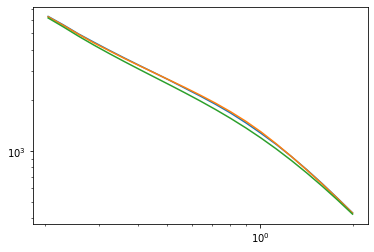

In [128]:
plt.loglog(obs_grid, obs_vec)
plt.loglog(obs_grid, fidu_mod)
plt.loglog(obs_grid, fidu_mod_lcdm)

In [129]:
sampler = run_emcee_mp(50, interp_model=Interpolation_Fits_loaded)

100%|██████████| 50/50 [01:35<00:00,  1.90s/it]


In [130]:
sampler

In [131]:
ndim =2

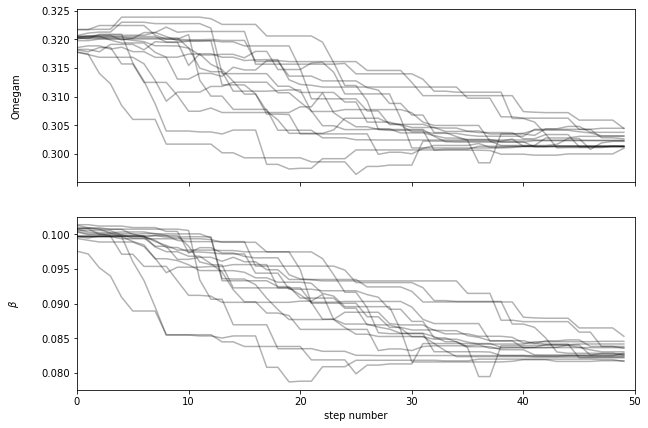

In [132]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Omegam", "$\\beta$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [133]:
flat_samples = sampler.get_chain( flat=True)

In [134]:
flat_samples

array([[0.32067149, 0.10074544],
       [0.32034866, 0.09975366],
       [0.32023446, 0.09970453],
       ...,
       [0.30374062, 0.08382045],
       [0.30313933, 0.08303443],
       [0.30095353, 0.08283119]])

In [135]:
np.savetxt('results/flat_chain_50_intp_fits.txt', flat_samples)

In [136]:
truth_beta

0.1

In [152]:
if 200 % 100:
    print("hola")

In [137]:
truth_omegam

0.32

In [143]:
import corner.corner as corner

In [144]:
corner.corner

<function corner.corner.corner.corner(xs, bins=20, range=None, weights=None, color='k', hist_bin_factor=1, smooth=None, smooth1d=None, labels=None, label_kwargs=None, show_titles=False, title_fmt='.2f', title_kwargs=None, truths=None, truth_color='#4682b4', scale_hist=False, quantiles=None, verbose=False, fig=None, max_n_ticks=5, top_ticks=False, use_math_text=False, reverse=False, hist_kwargs=None, **hist2d_kwargs)>

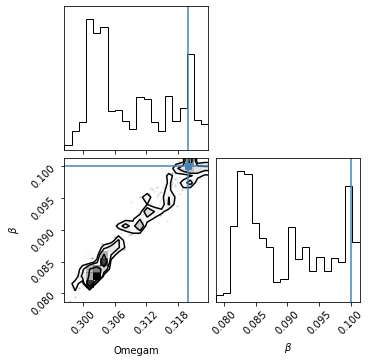

In [145]:
fig = corner.corner(flat_samples, labels=labels, truths=[truth_omegam, truth_beta]
);


In [146]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [33, 50, 67])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>